# How to Directly Access OCO-2 Data from an S3 Bucket with Python
### Author: Jon Hobbs, Alexis Hunzinger
### Date Authored: 6-10-25

### Timing

Exercise: 15 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook provides a quick demonstration on accessing and summarizing products from the Orbiting Carbon Observatory-2 (OCO-2) hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library, how to read data with xarray, and how to quickly compute and plot small-area aggregate estimates of atmospheric carbon dioxide.

Additional resources for identifying S3 URLs for NASA datasets and for accessing them can be found in the GES DISC cloud tutorials and documentation for the earthaccess Python library.

* [Obtain a List of S3 URLs](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Obtain_a_List_of_S3_URLs_for_GES_DISC_Collection_Using_Python.ipynb)
* [Accessing MERRA-2 from S3 Bucket](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Directly_Access_MERRA-2_Data_from_an_S3_Bucket.ipynb)
* [README for earthaccess Python library](https://github.com/nsidc/earthaccess)

The [OCO-2](https://doi.org/10.5067/70K2B2W8MNGY) and [OCO-3](https://doi.org/10.5067/8U0VGVQC7HZG) missions provide estimates of atmospheric carbon dioxide (XCO2) and solar-induced fluorescence (SIF) at fine spatial resolution with global coverage. This example examines XCO2, the column-averaged mole fraction of atmospheric carbon dioxide, from OCO-2. XCO2 is a scalar quantity reported in parts per million (ppm) and is spatially and temporally referenced. 

Most users of OCO-2 and OCO-3 XCO2 data work with the missions' *lite* products. These products are provided as global daily files at the original satellite spatial resolution of approximately 2 km by 1 km. The lite products include the XCO2 estimates, quality filtering information, and other diagnostics. Data users who combine the global data with geophysical models often choose to spatially aggregate these products, and this example highlights some simple approaches to accomplish this for quick visualization. 

## Import libraries

In [2]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np

import boto3
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

## AWS Region Check

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. An error message is displayed if outside of the AWS us-west-2 region. 

*This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.*

In [3]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

## Authentication

Access to NASA data requires NASA Earthdata authentication. We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` library as follows:

In [4]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## Search 

### Search for OCO-2 products in the CMR catalog using `earthaccess`

The product archive can be searched efficiently using the Common Metadata Repository (CMR) to identify 
products covering locations and time periods of interest. This example searches a 3-day span of the OCO-2 lite product archive.

Request the desired OCO-2 products for specified date range and product version (Version 11.1r). Here the search is by the product's short name. The [OCO-2 "lite" CO2 product](https://doi.org/10.5067/8E4VLCK16O6Q) is used for this analysis. 

In [5]:
short_name = 'OCO2_L2_Lite_FP'
version = '11.1r'
start_time = '2020-07-05'
end_time = '2020-07-07'

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    cloud_hosted=True,
    temporal=(start_time,end_time)
)

### Obtain S3 URLs for found granules

Now, the S3 URLs of the relevant products are extracted from the `results` object. 

In [6]:
s3_urls = [granule.data_links(access="direct")[0] for granule in results]
s3_urls

['s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200704_B11100Ar_230603215457s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200705_B11100Ar_230603215543s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200706_B11100Ar_230603215547s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200707_B11100Ar_230603215704s.nc4']

## Open granules using `earthaccess` and `xarray`

* A single OCO-2 lite product is accessed using the tools from `xarray` and `pandas`. 
* In addition to geolocation information and the XCO2 data, the `sounding_id` is extracted. OCO-2/3 identify each observation with a unique sounding ID, which also encodes a timestamp of the observation. 
* Observation quality information is available with the `xco2_quality_flag`, where values of 0 are assigned to the best quality observations. See also [OCO-2/3 data user's guide](https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_V11.2_OCO3_V11_L2_Data_Users_Guide_250304.pdf)
* The selected variables are assembled into a pandas data frame.
* A new variable `Sounding_10sec` is created, which truncates the sounding ID into a 10-second interval for later grouping and aggregation. Due to the OCO-2 sampling frequency, up to 240 observations could be grouped into the same 10-second interval.
* The data are subset to include only high-quality observations.

In [7]:
file_handlers = earthaccess.open(results)
ds = xr.open_dataset(file_handlers[0], decode_coords="all")

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
sounding_id = ds.sounding_id.values[:]
lat = ds.latitude.values[:]
lon = ds.longitude.values[:]
xco2 = ds.xco2.values[:]
quality_flag_xco2 = ds.xco2_quality_flag[:]

df = pd.DataFrame({'SoundingID': sounding_id, 
                          'Latitude': lat, 'Longitude': lon, 'XCO2': xco2, 'V11QFlag': quality_flag_xco2})
df['Sounding_10sec'] = np.floor(df['SoundingID'] / 1.0e3)
df = df[df['V11QFlag'] == 0]

In [9]:
df

,SoundingID,Latitude,Longitude,XCO2,V11QFlag,Sounding_10sec
34,2.020070e+15,-38.344372,-152.270706,411.636200,0.0,2.020070e+12
68,2.020070e+15,-36.668865,-152.755554,412.651978,0.0,2.020070e+12
92,2.020070e+15,-34.615337,-153.267776,410.651947,0.0,2.020070e+12
93,2.020070e+15,-34.608753,-153.290451,410.464233,0.0,2.020070e+12
100,2.020070e+15,-34.598209,-153.208237,411.708344,0.0,2.020070e+12
...,...,...,...,...,...,...
158269,2.020070e+15,78.992409,97.174576,412.261169,0.0,2.020070e+12
158271,2.020070e+15,79.022301,97.301666,413.505554,0.0,2.020070e+12
158274,2.020070e+15,78.985771,97.089539,410.017120,0.0,2.020070e+12
158282,2.020070e+15,79.002426,97.048065,410.701630,0.0,2.020070e+12


### Group and summarize

Construct a summary data frame that provides the median longitude, latitude, and XCO2 of observations within each 10-second block. This procedure will make use of the `groupby` and `apply` functionality for data frames. 

* Define a custom function `qsummary` that computes the median for selected variables in a data frame
* Group the OCO-2 data frame by 10-second interval and apply custom function to each group for selected variables

In [10]:
def qsummary(dataframe,group_var,var_list):
    # Summarize with quantiles
    n_match = dataframe.shape[0] 
    dataframe_out = pd.DataFrame({'NumSamples' : n_match}, index=[0])
    for j in range(len(var_list)):
        temp_datatable = dataframe[var_list[j]]
        datatable_valid = temp_datatable[np.isfinite(temp_datatable)]
        datatable_valid = datatable_valid[datatable_valid != 0.0]
        var_name = '%s_Med' % (var_list[j])
        dataframe_out[var_name] = np.median(datatable_valid)

    return dataframe_out

In [11]:
xco2_group = df.groupby(['Sounding_10sec'])
xco2_group_summary = xco2_group.apply(qsummary,group_var='Soundindg_10sec',var_list=['XCO2','Latitude','Longitude'])#,include_groups=False)
xco2_group_summary.reset_index(drop=False,inplace=True)
xco2_group_summary = xco2_group_summary[xco2_group_summary['NumSamples'] > 30]

# Plotting, mapping libraries

* Aggregated XCO2 data are mapped as colored points with the tools from  `cartopy` and `matplotlib` 

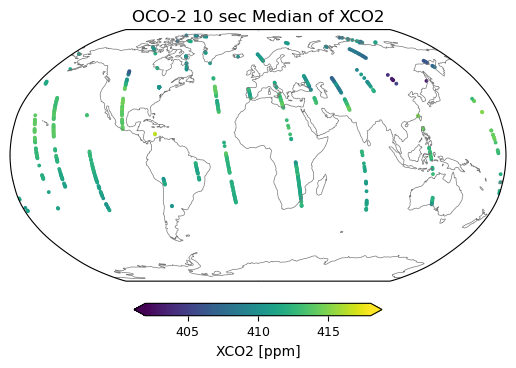

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline
trnsfrm = ccrs.PlateCarree()

# Set up figure
fig = plt.figure()

pmp = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
cs = plt.scatter(xco2_group_summary['Longitude_Med'],xco2_group_summary['Latitude_Med'],s=3, c=xco2_group_summary['XCO2_Med'], vmin=402, vmax=418, transform = trnsfrm)
pmp.coastlines(color='#777777',linewidth=0.5)
pmp.scatter([-180,180,0,0],[0,0,-90,90],s=0.01,c=None,transform=trnsfrm)

cbar = plt.colorbar(cs,extend='both',orientation='horizontal',shrink=0.5,pad=0.06)
cbar.set_label('XCO2 [ppm]',size=10)
cbar.ax.tick_params(labelsize=9)

tstr = 'OCO-2 10 sec Median of XCO2' 
plt.title(tstr)
plt.show()
